In [1]:
import requests, zipfile, io

def download_data():
    url = "https://cmp.felk.cvut.cz/~tylecr1/facade/CMP_facade_DB_base.zip"
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()

download_data()
     


In [1]:
from datasets import load_dataset
ds = load_dataset('Xpitfire/cmp_facade')

train_ds = ds['train']
eval_ds = ds['eval']
test_ds = ds['test']

Found cached dataset parquet (C:/Users/DooFromash/.cache/huggingface/datasets/Xpitfire___parquet/Xpitfire--cmp_facade-642b435710aeac91/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/3 [00:00<?, ?it/s]

In [2]:
ds

DatasetDict({
    eval: Dataset({
        features: ['pixel_values', 'label'],
        num_rows: 114
    })
    train: Dataset({
        features: ['pixel_values', 'label'],
        num_rows: 378
    })
    test: Dataset({
        features: ['pixel_values', 'label'],
        num_rows: 114
    })
})

# Import the labels

In [3]:
import numpy as np
from copy import deepcopy
from dataset.load_cmp import CMPDataset

# helper variables for ids and labels
id2label = CMPDataset.id2label
label2id = {v: k for k, v in id2label.items()}
unique_colors = CMPDataset.unique_colors
num_labels = CMPDataset.num_labels

# Prepare the data

In [4]:

import torch
import torchvision.transforms as T
from transformers import SegformerFeatureExtractor

feature_extractor = SegformerFeatureExtractor()
jitter = T.ColorJitter(brightness=0.25, contrast=0.25,
                       saturation=0.25, hue=0.1)
crop = T.RandomResizedCrop(512)
flip = T.RandomHorizontalFlip(0.5)


def train_transforms(example_batch):
    # color jettering
    images = [jitter(x) for x in example_batch['pixel_values']]

    # random crop
    images = [i for i in images]
    labels = [x for x in example_batch['label']]
    # get features and normalization
    inputs = feature_extractor(images, labels)

    # perform random cropping and flipping
    for i in range(len(inputs['pixel_values'])):
        # concatenate images
        image = torch.from_numpy(inputs['pixel_values'][i])
        target = torch.from_numpy(inputs['labels'][i]).view(
            1, *image.shape[1:]).expand_as(image)
        both_images = torch.cat((image.unsqueeze(0), target.unsqueeze(0)), 0)
        # Apply the transformations to both images simultaneously:
        transformed_images = crop(both_images)
        transformed_images = flip(both_images)
        # Get the transformed images:
        inputs['pixel_values'][i] = transformed_images[0].numpy()
        inputs['labels'][i] = transformed_images[1][0].to(torch.int64).numpy()
    return inputs


def val_transforms(example_batch):
    # do not perform any augmentation here
    images = [x for x in example_batch['pixel_values']]
    labels = [x for x in example_batch['label']]
    inputs = feature_extractor(images, labels)
    return inputs


# Set transforms
train_ds.set_transform(train_transforms)
eval_ds.set_transform(val_transforms)
# copy this to also have a version to show without transformations
test_ds_ori = deepcopy(test_ds)
test_ds.set_transform(val_transforms)
     

c:\Users\DooFromash\miniconda3\envs\mlxar\lib\site-packages\transformers\models\segformer\feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(


# Visualize

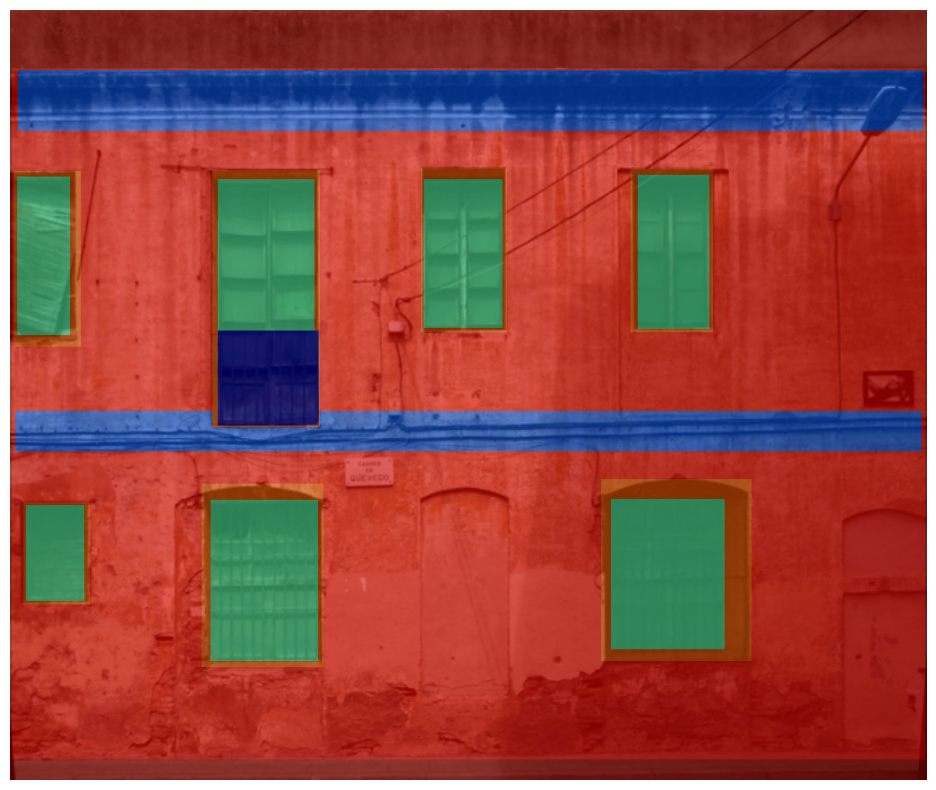

In [5]:
import matplotlib.pyplot as plt


def visualize_seg_mask(image: np.ndarray, mask: np.ndarray):
    color_seg = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    palette = np.array(unique_colors)
    for label, color in enumerate(palette):
        color_seg[mask == label, :] = color
    color_seg = color_seg[..., ::-1]  # convert to BGR

    # plot the image with the segmentation map
    img = np.array(image) * 0.5 + color_seg * 0.5
    img = img.astype(np.uint8)

    plt.figure(figsize=(15, 10))
    plt.imshow(img)
    plt.axis("off")
    plt.show()


# visualize the image + segmentation mask
visualize_seg_mask(
    np.array(test_ds_ori[0]['pixel_values']),
    np.array(test_ds_ori[0]['label'])
)


In [6]:
print("Number of training examples:", len(train_ds))
print("Number of validation examples:", len(eval_ds))
     

Number of training examples: 378
Number of validation examples: 114


In [7]:
encoded_inputs = train_ds[0]


In [8]:
encoded_inputs["pixel_values"].shape

(3, 512, 512)

In [9]:
encoded_inputs["labels"].shape

(512, 512)

In [10]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_ds, batch_size=2, shuffle=True)
valid_dataloader = DataLoader(eval_ds, batch_size=2)
     

In [11]:
batch = next(iter(train_dataloader))

In [12]:
for k,v in batch.items():
  print(k, v.shape)
     

pixel_values torch.Size([2, 3, 512, 512])
labels torch.Size([2, 512, 512])


In [13]:
batch["labels"].shape

torch.Size([2, 512, 512])

In [14]:
mask = (batch["labels"] != 0)
mask

tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]],

        [[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]])

In [15]:
batch["labels"][mask]

tensor([1, 1, 1,  ..., 1, 1, 1])

# Define the model

In [16]:
from transformers import SegformerForSemanticSegmentation
import json

# load id2label mapping from a JSON 


id2label = CMPDataset.id2label
label2id = {v: k for k, v in id2label.items()}
unique_colors = CMPDataset.unique_colors
num_labels = CMPDataset.num_labels


In [ ]:
import torch
from utils.segformer import get_configured_segformer

seg_model = get_configured_segformer(
    num_labels, criterion=None, load_imagenet_model=False)
seg_model.eval()
seg_model = torch.nn.DataParallel(seg_model)
ckpt_path = 'models/segformer_7data.pth'
checkpoint = torch.load(ckpt_path, map_location='cpu')['state_dict']
# exclude weights that are not used and cannot be tune for our task
ckpt_filter = {k: v for k, v in checkpoint.items(
) if 'criterion.0.criterion.weight' not in k}
ckpt_filter = {k: v for k, v in ckpt_filter.items(
) if 'module.segmodel.head' not in k}
ckpt_filter = {k: v for k, v in ckpt_filter.items(
) if 'module.segmodel.auxi_net' not in k}
ckpt_filter = {k: v for k, v in ckpt_filter.items(
) if 'module.segmodel.head.conv_seg.weight' not in k}


seg_model.load_state_dict(ckpt_filter, strict=False)


In [18]:
from typing import Optional, Union, Tuple
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from transformers import SegformerPreTrainedModel, SegformerConfig, SegformerDecodeHead
from transformers.modeling_outputs import SemanticSegmenterOutput


class CustomSegformerForSemanticSegmentation(SegformerPreTrainedModel):
    def __init__(self, config, seg_model):
        super().__init__(config)
        self.segformer = seg_model
        self.decode_head = SegformerDecodeHead(config)

        # Initialize weights and apply final processing
        self.post_init()

    def forward(
        self,
        pixel_values: torch.FloatTensor,
        labels: Optional[torch.LongTensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, SemanticSegmenterOutput]:
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )

        outputs = self.segformer(
            pixel_values,
        )
        logits = self.decode_head(outputs)

        loss = None
        if labels is not None:
            if not self.config.num_labels > 1:
                raise ValueError(
                    "The number of labels should be greater than one")
            else:
                # upsample logits to the images' original size
                upsampled_logits = nn.functional.interpolate(
                    logits, size=labels.shape[-2:], mode="bilinear", align_corners=False
                )
                loss_fct = CrossEntropyLoss(
                    ignore_index=self.config.semantic_loss_ignore_index)
                loss = loss_fct(upsampled_logits, labels)

        return SemanticSegmenterOutput(
            loss=loss,
            logits=logits,
            hidden_states=None,
            attentions=None,
        )


configuration = SegformerConfig(subnorm_type='batch',
                                semantic_loss_ignore_index=0,
                                hidden_sizes=[64, 128, 320, 512],
                                decoder_hidden_size=768,
                                num_labels=num_labels)
model = CustomSegformerForSemanticSegmentation(configuration,
                                               seg_model.module.segmodel.encoder).cuda()

# Fine-tune the model

In [19]:
from datasets import load_metric

metric = load_metric("mean_iou")

C:\Users\DooFromash\AppData\Local\Temp\ipykernel_1608\827884743.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("mean_iou")


In [20]:
import torch
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

# define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)
# move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.train()
for epoch in range(50):  # loop over the dataset multiple times
   print("Epoch:", epoch)
   for idx, batch in enumerate(tqdm(train_dataloader)):
        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits
        
        loss.backward()
        optimizer.step()

        # evaluate
        with torch.no_grad():
          upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
          predicted = upsampled_logits.argmax(dim=1)
          
          # note that the metric expects predictions + labels as numpy arrays
          metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

        # let's print loss and metrics every 100 batches
          if idx % 5 == 0:
            metrics = metric._compute(num_labels=len(id2label), 
                                    ignore_index=255,
                                    reduce_labels=False, # we've already reduced the labels before)
                                    predictions = predicted.detach().cpu().numpy(),
                                    references=labels.detach().cpu().numpy()
                                    
            )

          print("Loss:", loss.item())
          print("Mean_iou:", metrics["mean_iou"])
          print("Mean accuracy:", metrics["mean_accuracy"])
          print("Overall accuracy:", metrics["overall_accuracy"])

Epoch: 0


  0%|          | 0/189 [00:00<?, ?it/s]

C:\Users\DooFromash\.cache\huggingface\modules\datasets_modules\metrics\mean_iou\d4add40cf977cdd73590b5873fa830f3f13adb678f6777a29fb07b7c81d14342\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


Loss: 2.626821994781494
Mean_iou: 0.01919338269737268
Mean accuracy: 0.07912539294649883
Overall accuracy: 0.05840873718261719
Loss: 2.4729225635528564
Mean_iou: 0.01919338269737268
Mean accuracy: 0.07912539294649883
Overall accuracy: 0.05840873718261719
Loss: 2.689929246902466
Mean_iou: 0.01919338269737268
Mean accuracy: 0.07912539294649883
Overall accuracy: 0.05840873718261719
Loss: 2.480318546295166
Mean_iou: 0.01919338269737268
Mean accuracy: 0.07912539294649883
Overall accuracy: 0.05840873718261719
Loss: 2.7801151275634766
Mean_iou: 0.01919338269737268
Mean accuracy: 0.07912539294649883
Overall accuracy: 0.05840873718261719
Loss: 2.3681232929229736
Mean_iou: 0.06212272828060929
Mean accuracy: 0.10311556365657482
Overall accuracy: 0.2742595672607422
Loss: 2.5030741691589355
Mean_iou: 0.06212272828060929
Mean accuracy: 0.10311556365657482
Overall accuracy: 0.2742595672607422
Loss: 2.3654963970184326
Mean_iou: 0.06212272828060929
Mean accuracy: 0.10311556365657482
Overall accuracy: 0

C:\Users\DooFromash\.cache\huggingface\modules\datasets_modules\metrics\mean_iou\d4add40cf977cdd73590b5873fa830f3f13adb678f6777a29fb07b7c81d14342\mean_iou.py:258: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union


Loss: 2.267240047454834
Mean_iou: 0.06980315797992727
Mean accuracy: 0.15832926183478707
Overall accuracy: 0.3206634521484375
Loss: 2.4384498596191406
Mean_iou: 0.06980315797992727
Mean accuracy: 0.15832926183478707
Overall accuracy: 0.3206634521484375
Loss: 2.145181655883789
Mean_iou: 0.06980315797992727
Mean accuracy: 0.15832926183478707
Overall accuracy: 0.3206634521484375
Loss: 2.2201123237609863
Mean_iou: 0.06980315797992727
Mean accuracy: 0.15832926183478707
Overall accuracy: 0.3206634521484375
Loss: 2.5102598667144775
Mean_iou: 0.06980315797992727
Mean accuracy: 0.15832926183478707
Overall accuracy: 0.3206634521484375
Loss: 2.2605390548706055
Mean_iou: 0.0768571913703292
Mean accuracy: 0.1872170283231534
Overall accuracy: 0.3095989227294922
Loss: 2.4009671211242676
Mean_iou: 0.0768571913703292
Mean accuracy: 0.1872170283231534
Overall accuracy: 0.3095989227294922
Loss: 2.169064521789551
Mean_iou: 0.0768571913703292
Mean accuracy: 0.1872170283231534
Overall accuracy: 0.3095989227

  0%|          | 0/189 [00:00<?, ?it/s]

Loss: 1.5179340839385986
Mean_iou: 0.09968900475093712
Mean accuracy: 0.225401296485568
Overall accuracy: 0.4971427917480469
Loss: 1.7529183626174927
Mean_iou: 0.09968900475093712
Mean accuracy: 0.225401296485568
Overall accuracy: 0.4971427917480469
Loss: 1.9179425239562988
Mean_iou: 0.09968900475093712
Mean accuracy: 0.225401296485568
Overall accuracy: 0.4971427917480469
Loss: 1.6575123071670532
Mean_iou: 0.09968900475093712
Mean accuracy: 0.225401296485568
Overall accuracy: 0.4971427917480469
Loss: 1.5151777267456055
Mean_iou: 0.09968900475093712
Mean accuracy: 0.225401296485568
Overall accuracy: 0.4971427917480469
Loss: 1.536145806312561
Mean_iou: 0.09241748110580249
Mean accuracy: 0.14613986817921495
Overall accuracy: 0.48426055908203125
Loss: 1.9843640327453613
Mean_iou: 0.09241748110580249
Mean accuracy: 0.14613986817921495
Overall accuracy: 0.48426055908203125
Loss: 1.991156816482544
Mean_iou: 0.09241748110580249
Mean accuracy: 0.14613986817921495
Overall accuracy: 0.48426055908

  0%|          | 0/189 [00:00<?, ?it/s]

Loss: 1.9998213052749634
Mean_iou: 0.07146623131720284
Mean accuracy: 0.13111546993542453
Overall accuracy: 0.3336467742919922
Loss: 0.9914696216583252
Mean_iou: 0.07146623131720284
Mean accuracy: 0.13111546993542453
Overall accuracy: 0.3336467742919922
Loss: 1.5479215383529663
Mean_iou: 0.07146623131720284
Mean accuracy: 0.13111546993542453
Overall accuracy: 0.3336467742919922
Loss: 1.491953730583191
Mean_iou: 0.07146623131720284
Mean accuracy: 0.13111546993542453
Overall accuracy: 0.3336467742919922
Loss: 1.1832422018051147
Mean_iou: 0.07146623131720284
Mean accuracy: 0.13111546993542453
Overall accuracy: 0.3336467742919922
Loss: 1.3943123817443848
Mean_iou: 0.19611642988863667
Mean accuracy: 0.39828696289012083
Overall accuracy: 0.5738811492919922
Loss: 1.1327800750732422
Mean_iou: 0.19611642988863667
Mean accuracy: 0.39828696289012083
Overall accuracy: 0.5738811492919922
Loss: 1.3030660152435303
Mean_iou: 0.19611642988863667
Mean accuracy: 0.39828696289012083
Overall accuracy: 0.57

  0%|          | 0/189 [00:00<?, ?it/s]

Loss: 1.510908603668213
Mean_iou: 0.11586112778313627
Mean accuracy: 0.23916989876240616
Overall accuracy: 0.46051788330078125
Loss: 1.2831743955612183
Mean_iou: 0.11586112778313627
Mean accuracy: 0.23916989876240616
Overall accuracy: 0.46051788330078125
Loss: 1.4213435649871826
Mean_iou: 0.11586112778313627
Mean accuracy: 0.23916989876240616
Overall accuracy: 0.46051788330078125
Loss: 1.305371642112732
Mean_iou: 0.11586112778313627
Mean accuracy: 0.23916989876240616
Overall accuracy: 0.46051788330078125
Loss: 1.3767521381378174
Mean_iou: 0.11586112778313627
Mean accuracy: 0.23916989876240616
Overall accuracy: 0.46051788330078125
Loss: 1.155517816543579
Mean_iou: 0.15339666592743925
Mean accuracy: 0.24697790245454992
Overall accuracy: 0.6133079528808594
Loss: 1.2471787929534912
Mean_iou: 0.15339666592743925
Mean accuracy: 0.24697790245454992
Overall accuracy: 0.6133079528808594
Loss: 1.3822708129882812
Mean_iou: 0.15339666592743925
Mean accuracy: 0.24697790245454992
Overall accuracy: 0

  0%|          | 0/189 [00:00<?, ?it/s]

Loss: 1.4840285778045654
Mean_iou: 0.1360113066816937
Mean accuracy: 0.2085251352733609
Overall accuracy: 0.49383544921875
Loss: 1.6222782135009766
Mean_iou: 0.1360113066816937
Mean accuracy: 0.2085251352733609
Overall accuracy: 0.49383544921875
Loss: 1.5344687700271606
Mean_iou: 0.1360113066816937
Mean accuracy: 0.2085251352733609
Overall accuracy: 0.49383544921875
Loss: 1.2557642459869385
Mean_iou: 0.1360113066816937
Mean accuracy: 0.2085251352733609
Overall accuracy: 0.49383544921875
Loss: 1.0349061489105225
Mean_iou: 0.1360113066816937
Mean accuracy: 0.2085251352733609
Overall accuracy: 0.49383544921875
Loss: 1.168609380722046
Mean_iou: 0.23665454838950922
Mean accuracy: 0.3825053305690246
Overall accuracy: 0.5867576599121094
Loss: 1.2149109840393066
Mean_iou: 0.23665454838950922
Mean accuracy: 0.3825053305690246
Overall accuracy: 0.5867576599121094
Loss: 1.7394380569458008
Mean_iou: 0.23665454838950922
Mean accuracy: 0.3825053305690246
Overall accuracy: 0.5867576599121094
Loss: 1.

  0%|          | 0/189 [00:00<?, ?it/s]

Loss: 1.0126433372497559
Mean_iou: 0.1801076380789837
Mean accuracy: 0.37910757552450397
Overall accuracy: 0.6766223907470703
Loss: 1.0916416645050049
Mean_iou: 0.1801076380789837
Mean accuracy: 0.37910757552450397
Overall accuracy: 0.6766223907470703
Loss: 1.3200228214263916
Mean_iou: 0.1801076380789837
Mean accuracy: 0.37910757552450397
Overall accuracy: 0.6766223907470703
Loss: 1.3002281188964844
Mean_iou: 0.1801076380789837
Mean accuracy: 0.37910757552450397
Overall accuracy: 0.6766223907470703
Loss: 1.4844298362731934
Mean_iou: 0.1801076380789837
Mean accuracy: 0.37910757552450397
Overall accuracy: 0.6766223907470703
Loss: 1.2421892881393433
Mean_iou: 0.1930726641298209
Mean accuracy: 0.26256541731837935
Overall accuracy: 0.5884418487548828
Loss: 1.2447036504745483
Mean_iou: 0.1930726641298209
Mean accuracy: 0.26256541731837935
Overall accuracy: 0.5884418487548828
Loss: 1.1741214990615845
Mean_iou: 0.1930726641298209
Mean accuracy: 0.26256541731837935
Overall accuracy: 0.588441848

  0%|          | 0/189 [00:00<?, ?it/s]

Loss: 1.3461320400238037
Mean_iou: 0.18456642879119292
Mean accuracy: 0.25703959090363465
Overall accuracy: 0.5136585235595703
Loss: 1.4247932434082031
Mean_iou: 0.18456642879119292
Mean accuracy: 0.25703959090363465
Overall accuracy: 0.5136585235595703
Loss: 1.1782798767089844
Mean_iou: 0.18456642879119292
Mean accuracy: 0.25703959090363465
Overall accuracy: 0.5136585235595703
Loss: 1.147882103919983
Mean_iou: 0.18456642879119292
Mean accuracy: 0.25703959090363465
Overall accuracy: 0.5136585235595703
Loss: 1.3240938186645508
Mean_iou: 0.18456642879119292
Mean accuracy: 0.25703959090363465
Overall accuracy: 0.5136585235595703
Loss: 1.3083324432373047
Mean_iou: 0.19297915793389275
Mean accuracy: 0.27852249239551036
Overall accuracy: 0.5600757598876953
Loss: 1.3425922393798828
Mean_iou: 0.19297915793389275
Mean accuracy: 0.27852249239551036
Overall accuracy: 0.5600757598876953
Loss: 1.1446161270141602
Mean_iou: 0.19297915793389275
Mean accuracy: 0.27852249239551036
Overall accuracy: 0.56

  0%|          | 0/189 [00:00<?, ?it/s]

Loss: 0.9335689544677734
Mean_iou: 0.30677856870334635
Mean accuracy: 0.41566052268979037
Overall accuracy: 0.7038803100585938
Loss: 1.0701367855072021
Mean_iou: 0.30677856870334635
Mean accuracy: 0.41566052268979037
Overall accuracy: 0.7038803100585938
Loss: 1.2575048208236694
Mean_iou: 0.30677856870334635
Mean accuracy: 0.41566052268979037
Overall accuracy: 0.7038803100585938
Loss: 1.3895583152770996
Mean_iou: 0.30677856870334635
Mean accuracy: 0.41566052268979037
Overall accuracy: 0.7038803100585938
Loss: 1.0923643112182617
Mean_iou: 0.30677856870334635
Mean accuracy: 0.41566052268979037
Overall accuracy: 0.7038803100585938
Loss: 0.7678394913673401
Mean_iou: 0.2603572711871707
Mean accuracy: 0.3829780527533708
Overall accuracy: 0.7531814575195312
Loss: 1.1859325170516968
Mean_iou: 0.2603572711871707
Mean accuracy: 0.3829780527533708
Overall accuracy: 0.7531814575195312
Loss: 0.9636905789375305
Mean_iou: 0.2603572711871707
Mean accuracy: 0.3829780527533708
Overall accuracy: 0.7531814

  0%|          | 0/189 [00:00<?, ?it/s]

Loss: 1.114843726158142
Mean_iou: 0.17969135048233273
Mean accuracy: 0.26131517218501893
Overall accuracy: 0.6288986206054688
Loss: 1.4444156885147095
Mean_iou: 0.17969135048233273
Mean accuracy: 0.26131517218501893
Overall accuracy: 0.6288986206054688
Loss: 1.723976731300354
Mean_iou: 0.17969135048233273
Mean accuracy: 0.26131517218501893
Overall accuracy: 0.6288986206054688
Loss: 1.1997389793395996
Mean_iou: 0.17969135048233273
Mean accuracy: 0.26131517218501893
Overall accuracy: 0.6288986206054688
Loss: 1.3158015012741089
Mean_iou: 0.17969135048233273
Mean accuracy: 0.26131517218501893
Overall accuracy: 0.6288986206054688
Loss: 1.148383617401123
Mean_iou: 0.164264940677478
Mean accuracy: 0.38677359196089833
Overall accuracy: 0.5809364318847656
Loss: 1.152469515800476
Mean_iou: 0.164264940677478
Mean accuracy: 0.38677359196089833
Overall accuracy: 0.5809364318847656
Loss: 1.308782935142517
Mean_iou: 0.164264940677478
Mean accuracy: 0.38677359196089833
Overall accuracy: 0.580936431884

  0%|          | 0/189 [00:00<?, ?it/s]

Loss: 0.9934435486793518
Mean_iou: 0.25170397359057145
Mean accuracy: 0.37171728839108925
Overall accuracy: 0.6445522308349609
Loss: 1.116507887840271
Mean_iou: 0.25170397359057145
Mean accuracy: 0.37171728839108925
Overall accuracy: 0.6445522308349609
Loss: 0.9676262140274048
Mean_iou: 0.25170397359057145
Mean accuracy: 0.37171728839108925
Overall accuracy: 0.6445522308349609
Loss: 1.3980613946914673
Mean_iou: 0.25170397359057145
Mean accuracy: 0.37171728839108925
Overall accuracy: 0.6445522308349609
Loss: 1.0147733688354492
Mean_iou: 0.25170397359057145
Mean accuracy: 0.37171728839108925
Overall accuracy: 0.6445522308349609
Loss: 1.2099463939666748
Mean_iou: 0.2367070012113486
Mean accuracy: 0.396937758596105
Overall accuracy: 0.6096000671386719
Loss: 0.8235247135162354
Mean_iou: 0.2367070012113486
Mean accuracy: 0.396937758596105
Overall accuracy: 0.6096000671386719
Loss: 1.0944446325302124
Mean_iou: 0.2367070012113486
Mean accuracy: 0.396937758596105
Overall accuracy: 0.60960006713

  0%|          | 0/189 [00:00<?, ?it/s]

Loss: 1.0944262742996216
Mean_iou: 0.20697072037609907
Mean accuracy: 0.35795815137547193
Overall accuracy: 0.5910758972167969
Loss: 1.6609820127487183
Mean_iou: 0.20697072037609907
Mean accuracy: 0.35795815137547193
Overall accuracy: 0.5910758972167969
Loss: 1.2177116870880127
Mean_iou: 0.20697072037609907
Mean accuracy: 0.35795815137547193
Overall accuracy: 0.5910758972167969
Loss: 1.4175302982330322
Mean_iou: 0.20697072037609907
Mean accuracy: 0.35795815137547193
Overall accuracy: 0.5910758972167969
Loss: 1.028238296508789
Mean_iou: 0.20697072037609907
Mean accuracy: 0.35795815137547193
Overall accuracy: 0.5910758972167969
Loss: 0.9779574871063232
Mean_iou: 0.24269272672186737
Mean accuracy: 0.36821885856100245
Overall accuracy: 0.6634140014648438
Loss: 1.2150943279266357
Mean_iou: 0.24269272672186737
Mean accuracy: 0.36821885856100245
Overall accuracy: 0.6634140014648438
Loss: 1.0714744329452515
Mean_iou: 0.24269272672186737
Mean accuracy: 0.36821885856100245
Overall accuracy: 0.66

  0%|          | 0/189 [00:00<?, ?it/s]

Loss: 1.1983513832092285
Mean_iou: 0.18067267902895878
Mean accuracy: 0.31325665392819146
Overall accuracy: 0.5246238708496094
Loss: 1.0281836986541748
Mean_iou: 0.18067267902895878
Mean accuracy: 0.31325665392819146
Overall accuracy: 0.5246238708496094
Loss: 0.8889771103858948
Mean_iou: 0.18067267902895878
Mean accuracy: 0.31325665392819146
Overall accuracy: 0.5246238708496094
Loss: 0.8494120240211487
Mean_iou: 0.18067267902895878
Mean accuracy: 0.31325665392819146
Overall accuracy: 0.5246238708496094
Loss: 1.2419941425323486
Mean_iou: 0.18067267902895878
Mean accuracy: 0.31325665392819146
Overall accuracy: 0.5246238708496094
Loss: 1.0045772790908813
Mean_iou: 0.3130411526810902
Mean accuracy: 0.4056340085174932
Overall accuracy: 0.6963672637939453
Loss: 0.9486894011497498
Mean_iou: 0.3130411526810902
Mean accuracy: 0.4056340085174932
Overall accuracy: 0.6963672637939453
Loss: 0.8885388970375061
Mean_iou: 0.3130411526810902
Mean accuracy: 0.4056340085174932
Overall accuracy: 0.6963672

  0%|          | 0/189 [00:00<?, ?it/s]

Loss: 0.9245727062225342
Mean_iou: 0.23945772951684233
Mean accuracy: 0.46176717109788845
Overall accuracy: 0.6999034881591797
Loss: 0.9749630689620972
Mean_iou: 0.23945772951684233
Mean accuracy: 0.46176717109788845
Overall accuracy: 0.6999034881591797
Loss: 0.94478440284729
Mean_iou: 0.23945772951684233
Mean accuracy: 0.46176717109788845
Overall accuracy: 0.6999034881591797
Loss: 1.0777616500854492
Mean_iou: 0.23945772951684233
Mean accuracy: 0.46176717109788845
Overall accuracy: 0.6999034881591797
Loss: 1.0845415592193604
Mean_iou: 0.23945772951684233
Mean accuracy: 0.46176717109788845
Overall accuracy: 0.6999034881591797
Loss: 1.3771318197250366
Mean_iou: 0.16627635855549303
Mean accuracy: 0.27967199526286585
Overall accuracy: 0.5253734588623047
Loss: 0.8276336193084717
Mean_iou: 0.16627635855549303
Mean accuracy: 0.27967199526286585
Overall accuracy: 0.5253734588623047
Loss: 0.8840166926383972
Mean_iou: 0.16627635855549303
Mean accuracy: 0.27967199526286585
Overall accuracy: 0.525

  0%|          | 0/189 [00:00<?, ?it/s]

Loss: 1.033064365386963
Mean_iou: 0.21175068245349662
Mean accuracy: 0.3853154298186785
Overall accuracy: 0.6382369995117188
Loss: 0.8604463934898376
Mean_iou: 0.21175068245349662
Mean accuracy: 0.3853154298186785
Overall accuracy: 0.6382369995117188
Loss: 1.0425615310668945
Mean_iou: 0.21175068245349662
Mean accuracy: 0.3853154298186785
Overall accuracy: 0.6382369995117188
Loss: 0.8279679417610168
Mean_iou: 0.21175068245349662
Mean accuracy: 0.3853154298186785
Overall accuracy: 0.6382369995117188
Loss: 1.422987461090088
Mean_iou: 0.21175068245349662
Mean accuracy: 0.3853154298186785
Overall accuracy: 0.6382369995117188
Loss: 0.8568300008773804
Mean_iou: 0.2599967825958565
Mean accuracy: 0.41455095488695776
Overall accuracy: 0.7429256439208984
Loss: 0.846002459526062
Mean_iou: 0.2599967825958565
Mean accuracy: 0.41455095488695776
Overall accuracy: 0.7429256439208984
Loss: 1.0069864988327026
Mean_iou: 0.2599967825958565
Mean accuracy: 0.41455095488695776
Overall accuracy: 0.742925643920

  0%|          | 0/189 [00:00<?, ?it/s]

Loss: 0.8550493717193604
Mean_iou: 0.35388682413027817
Mean accuracy: 0.44582581927826603
Overall accuracy: 0.7219963073730469
Loss: 0.8678419589996338
Mean_iou: 0.35388682413027817
Mean accuracy: 0.44582581927826603
Overall accuracy: 0.7219963073730469
Loss: 0.6693317890167236
Mean_iou: 0.35388682413027817
Mean accuracy: 0.44582581927826603
Overall accuracy: 0.7219963073730469
Loss: 1.5432316064834595
Mean_iou: 0.35388682413027817
Mean accuracy: 0.44582581927826603
Overall accuracy: 0.7219963073730469
Loss: 0.8756296038627625
Mean_iou: 0.35388682413027817
Mean accuracy: 0.44582581927826603
Overall accuracy: 0.7219963073730469
Loss: 0.901619553565979
Mean_iou: 0.2975570677233041
Mean accuracy: 0.5070600466892229
Overall accuracy: 0.6721591949462891
Loss: 1.1245793104171753
Mean_iou: 0.2975570677233041
Mean accuracy: 0.5070600466892229
Overall accuracy: 0.6721591949462891
Loss: 0.7997280955314636
Mean_iou: 0.2975570677233041
Mean accuracy: 0.5070600466892229
Overall accuracy: 0.67215919

  0%|          | 0/189 [00:00<?, ?it/s]

Loss: 0.887753427028656
Mean_iou: 0.38894851864759944
Mean accuracy: 0.5457782668973917
Overall accuracy: 0.6863918304443359
Loss: 0.8532074093818665
Mean_iou: 0.38894851864759944
Mean accuracy: 0.5457782668973917
Overall accuracy: 0.6863918304443359
Loss: 0.9398881793022156
Mean_iou: 0.38894851864759944
Mean accuracy: 0.5457782668973917
Overall accuracy: 0.6863918304443359
Loss: 0.9112862348556519
Mean_iou: 0.38894851864759944
Mean accuracy: 0.5457782668973917
Overall accuracy: 0.6863918304443359
Loss: 0.7783470153808594
Mean_iou: 0.38894851864759944
Mean accuracy: 0.5457782668973917
Overall accuracy: 0.6863918304443359
Loss: 1.069622278213501
Mean_iou: 0.22984525893793825
Mean accuracy: 0.31851841743307613
Overall accuracy: 0.6492748260498047
Loss: 0.7953134775161743
Mean_iou: 0.22984525893793825
Mean accuracy: 0.31851841743307613
Overall accuracy: 0.6492748260498047
Loss: 0.9035456776618958
Mean_iou: 0.22984525893793825
Mean accuracy: 0.31851841743307613
Overall accuracy: 0.64927482

  0%|          | 0/189 [00:00<?, ?it/s]

Loss: 0.8950408697128296
Mean_iou: 0.2871007653786797
Mean accuracy: 0.3729781524044986
Overall accuracy: 0.6817035675048828
Loss: 0.8633907437324524
Mean_iou: 0.2871007653786797
Mean accuracy: 0.3729781524044986
Overall accuracy: 0.6817035675048828
Loss: 1.1124049425125122
Mean_iou: 0.2871007653786797
Mean accuracy: 0.3729781524044986
Overall accuracy: 0.6817035675048828
Loss: 1.0413103103637695
Mean_iou: 0.2871007653786797
Mean accuracy: 0.3729781524044986
Overall accuracy: 0.6817035675048828
Loss: 0.9914662837982178
Mean_iou: 0.2871007653786797
Mean accuracy: 0.3729781524044986
Overall accuracy: 0.6817035675048828
Loss: 1.2145800590515137
Mean_iou: 0.24890753427843687
Mean accuracy: 0.4074098828084389
Overall accuracy: 0.5415706634521484
Loss: 0.7584069967269897
Mean_iou: 0.24890753427843687
Mean accuracy: 0.4074098828084389
Overall accuracy: 0.5415706634521484
Loss: 0.9309195876121521
Mean_iou: 0.24890753427843687
Mean accuracy: 0.4074098828084389
Overall accuracy: 0.54157066345214

  0%|          | 0/189 [00:00<?, ?it/s]

Loss: 0.8292398452758789
Mean_iou: 0.4288679254502728
Mean accuracy: 0.5353209749661342
Overall accuracy: 0.7271919250488281
Loss: 1.0252156257629395
Mean_iou: 0.4288679254502728
Mean accuracy: 0.5353209749661342
Overall accuracy: 0.7271919250488281
Loss: 1.0107176303863525
Mean_iou: 0.4288679254502728
Mean accuracy: 0.5353209749661342
Overall accuracy: 0.7271919250488281
Loss: 0.7172616720199585
Mean_iou: 0.4288679254502728
Mean accuracy: 0.5353209749661342
Overall accuracy: 0.7271919250488281
Loss: 0.8779773116111755
Mean_iou: 0.4288679254502728
Mean accuracy: 0.5353209749661342
Overall accuracy: 0.7271919250488281
Loss: 0.9753016829490662
Mean_iou: 0.1943069672287949
Mean accuracy: 0.34546141171166017
Overall accuracy: 0.6821670532226562
Loss: 0.8616090416908264
Mean_iou: 0.1943069672287949
Mean accuracy: 0.34546141171166017
Overall accuracy: 0.6821670532226562
Loss: 0.8767287135124207
Mean_iou: 0.1943069672287949
Mean accuracy: 0.34546141171166017
Overall accuracy: 0.68216705322265

  0%|          | 0/189 [00:00<?, ?it/s]

Loss: 1.0747424364089966
Mean_iou: 0.2522216363213747
Mean accuracy: 0.38816553551872074
Overall accuracy: 0.6832695007324219
Loss: 0.9249361753463745
Mean_iou: 0.2522216363213747
Mean accuracy: 0.38816553551872074
Overall accuracy: 0.6832695007324219
Loss: 1.0647947788238525
Mean_iou: 0.2522216363213747
Mean accuracy: 0.38816553551872074
Overall accuracy: 0.6832695007324219
Loss: 1.110943078994751
Mean_iou: 0.2522216363213747
Mean accuracy: 0.38816553551872074
Overall accuracy: 0.6832695007324219
Loss: 0.8437231779098511
Mean_iou: 0.2522216363213747
Mean accuracy: 0.38816553551872074
Overall accuracy: 0.6832695007324219
Loss: 0.7511246800422668
Mean_iou: 0.3393441167274791
Mean accuracy: 0.4942147106869473
Overall accuracy: 0.7342300415039062
Loss: 0.7231826782226562
Mean_iou: 0.3393441167274791
Mean accuracy: 0.4942147106869473
Overall accuracy: 0.7342300415039062
Loss: 0.8594514727592468
Mean_iou: 0.3393441167274791
Mean accuracy: 0.4942147106869473
Overall accuracy: 0.7342300415039

  0%|          | 0/189 [00:00<?, ?it/s]

Loss: 0.9983595609664917
Mean_iou: 0.3058018471773914
Mean accuracy: 0.42350254847288044
Overall accuracy: 0.6696262359619141
Loss: 0.7748551368713379
Mean_iou: 0.3058018471773914
Mean accuracy: 0.42350254847288044
Overall accuracy: 0.6696262359619141
Loss: 0.7888144254684448
Mean_iou: 0.3058018471773914
Mean accuracy: 0.42350254847288044
Overall accuracy: 0.6696262359619141
Loss: 0.9541302919387817
Mean_iou: 0.3058018471773914
Mean accuracy: 0.42350254847288044
Overall accuracy: 0.6696262359619141
Loss: 0.8910965919494629
Mean_iou: 0.3058018471773914
Mean accuracy: 0.42350254847288044
Overall accuracy: 0.6696262359619141
Loss: 0.6949578523635864
Mean_iou: 0.3851672394467638
Mean accuracy: 0.5694800164769832
Overall accuracy: 0.7736911773681641
Loss: 0.5628277659416199
Mean_iou: 0.3851672394467638
Mean accuracy: 0.5694800164769832
Overall accuracy: 0.7736911773681641
Loss: 0.7400417923927307
Mean_iou: 0.3851672394467638
Mean accuracy: 0.5694800164769832
Overall accuracy: 0.773691177368

  0%|          | 0/189 [00:00<?, ?it/s]

Loss: 0.9485766887664795
Mean_iou: 0.3708780462345818
Mean accuracy: 0.4671769276302391
Overall accuracy: 0.6706123352050781
Loss: 0.6790943145751953
Mean_iou: 0.3708780462345818
Mean accuracy: 0.4671769276302391
Overall accuracy: 0.6706123352050781
Loss: 0.741629958152771
Mean_iou: 0.3708780462345818
Mean accuracy: 0.4671769276302391
Overall accuracy: 0.6706123352050781
Loss: 0.5986095070838928
Mean_iou: 0.3708780462345818
Mean accuracy: 0.4671769276302391
Overall accuracy: 0.6706123352050781
Loss: 0.8060151934623718
Mean_iou: 0.3708780462345818
Mean accuracy: 0.4671769276302391
Overall accuracy: 0.6706123352050781
Loss: 0.6790469884872437
Mean_iou: 0.26584924637992063
Mean accuracy: 0.4113333496861861
Overall accuracy: 0.7685699462890625
Loss: 0.6564799547195435
Mean_iou: 0.26584924637992063
Mean accuracy: 0.4113333496861861
Overall accuracy: 0.7685699462890625
Loss: 0.9083538055419922
Mean_iou: 0.26584924637992063
Mean accuracy: 0.4113333496861861
Overall accuracy: 0.768569946289062

  0%|          | 0/189 [00:00<?, ?it/s]

Loss: 0.863821804523468
Mean_iou: 0.33804384351535516
Mean accuracy: 0.5065780570148873
Overall accuracy: 0.7130870819091797
Loss: 1.1083099842071533
Mean_iou: 0.33804384351535516
Mean accuracy: 0.5065780570148873
Overall accuracy: 0.7130870819091797
Loss: 0.767742931842804
Mean_iou: 0.33804384351535516
Mean accuracy: 0.5065780570148873
Overall accuracy: 0.7130870819091797
Loss: 0.8451650738716125
Mean_iou: 0.33804384351535516
Mean accuracy: 0.5065780570148873
Overall accuracy: 0.7130870819091797
Loss: 1.0256354808807373
Mean_iou: 0.33804384351535516
Mean accuracy: 0.5065780570148873
Overall accuracy: 0.7130870819091797
Loss: 0.8276317715644836
Mean_iou: 0.36972839864982693
Mean accuracy: 0.5346079884691232
Overall accuracy: 0.7161121368408203
Loss: 0.7338298559188843
Mean_iou: 0.36972839864982693
Mean accuracy: 0.5346079884691232
Overall accuracy: 0.7161121368408203
Loss: 0.6862716674804688
Mean_iou: 0.36972839864982693
Mean accuracy: 0.5346079884691232
Overall accuracy: 0.71611213684

  0%|          | 0/189 [00:00<?, ?it/s]

Loss: 0.6025079488754272
Mean_iou: 0.41030198442712
Mean accuracy: 0.5967133214274605
Overall accuracy: 0.7915229797363281
Loss: 0.8638295531272888
Mean_iou: 0.41030198442712
Mean accuracy: 0.5967133214274605
Overall accuracy: 0.7915229797363281
Loss: 0.7096357345581055
Mean_iou: 0.41030198442712
Mean accuracy: 0.5967133214274605
Overall accuracy: 0.7915229797363281
Loss: 0.8910678625106812
Mean_iou: 0.41030198442712
Mean accuracy: 0.5967133214274605
Overall accuracy: 0.7915229797363281
Loss: 0.9216658473014832
Mean_iou: 0.41030198442712
Mean accuracy: 0.5967133214274605
Overall accuracy: 0.7915229797363281
Loss: 0.7294687032699585
Mean_iou: 0.37459103028775326
Mean accuracy: 0.5063481034425997
Overall accuracy: 0.7441635131835938
Loss: 0.8639011979103088
Mean_iou: 0.37459103028775326
Mean accuracy: 0.5063481034425997
Overall accuracy: 0.7441635131835938
Loss: 0.9529228210449219
Mean_iou: 0.37459103028775326
Mean accuracy: 0.5063481034425997
Overall accuracy: 0.7441635131835938
Loss: 0

  0%|          | 0/189 [00:00<?, ?it/s]

Loss: 0.7169725894927979
Mean_iou: 0.30175518608802854
Mean accuracy: 0.39224033435149225
Overall accuracy: 0.7727069854736328
Loss: 0.7872999906539917
Mean_iou: 0.30175518608802854
Mean accuracy: 0.39224033435149225
Overall accuracy: 0.7727069854736328
Loss: 0.8688675165176392
Mean_iou: 0.30175518608802854
Mean accuracy: 0.39224033435149225
Overall accuracy: 0.7727069854736328
Loss: 0.6688898801803589
Mean_iou: 0.30175518608802854
Mean accuracy: 0.39224033435149225
Overall accuracy: 0.7727069854736328
Loss: 1.0009021759033203
Mean_iou: 0.30175518608802854
Mean accuracy: 0.39224033435149225
Overall accuracy: 0.7727069854736328
Loss: 0.7454816102981567
Mean_iou: 0.3343693191075458
Mean accuracy: 0.49638964511235295
Overall accuracy: 0.7511940002441406
Loss: 0.7784906625747681
Mean_iou: 0.3343693191075458
Mean accuracy: 0.49638964511235295
Overall accuracy: 0.7511940002441406
Loss: 0.9061059355735779
Mean_iou: 0.3343693191075458
Mean accuracy: 0.49638964511235295
Overall accuracy: 0.7511

  0%|          | 0/189 [00:00<?, ?it/s]

Loss: 0.6973034739494324
Mean_iou: 0.46883563936683514
Mean accuracy: 0.5677871605865603
Overall accuracy: 0.7361640930175781
Loss: 0.6803221702575684
Mean_iou: 0.46883563936683514
Mean accuracy: 0.5677871605865603
Overall accuracy: 0.7361640930175781
Loss: 0.7940237522125244
Mean_iou: 0.46883563936683514
Mean accuracy: 0.5677871605865603
Overall accuracy: 0.7361640930175781
Loss: 0.8433897495269775
Mean_iou: 0.46883563936683514
Mean accuracy: 0.5677871605865603
Overall accuracy: 0.7361640930175781
Loss: 0.6114342212677002
Mean_iou: 0.46883563936683514
Mean accuracy: 0.5677871605865603
Overall accuracy: 0.7361640930175781
Loss: 0.6559751033782959
Mean_iou: 0.4098467058749231
Mean accuracy: 0.5797077589749711
Overall accuracy: 0.7818546295166016
Loss: 0.7159132957458496
Mean_iou: 0.4098467058749231
Mean accuracy: 0.5797077589749711
Overall accuracy: 0.7818546295166016
Loss: 0.6284036636352539
Mean_iou: 0.4098467058749231
Mean accuracy: 0.5797077589749711
Overall accuracy: 0.781854629516

  0%|          | 0/189 [00:00<?, ?it/s]

Loss: 0.6934345960617065
Mean_iou: 0.2889948406012476
Mean accuracy: 0.40406392063645313
Overall accuracy: 0.7677249908447266
Loss: 0.5936823487281799
Mean_iou: 0.2889948406012476
Mean accuracy: 0.40406392063645313
Overall accuracy: 0.7677249908447266
Loss: 0.9023850560188293
Mean_iou: 0.2889948406012476
Mean accuracy: 0.40406392063645313
Overall accuracy: 0.7677249908447266
Loss: 0.702111542224884
Mean_iou: 0.2889948406012476
Mean accuracy: 0.40406392063645313
Overall accuracy: 0.7677249908447266
Loss: 0.7027957439422607
Mean_iou: 0.2889948406012476
Mean accuracy: 0.40406392063645313
Overall accuracy: 0.7677249908447266
Loss: 0.7994285225868225
Mean_iou: 0.37755279915490064
Mean accuracy: 0.5282595244466763
Overall accuracy: 0.7119140625
Loss: 0.6694582104682922
Mean_iou: 0.37755279915490064
Mean accuracy: 0.5282595244466763
Overall accuracy: 0.7119140625
Loss: 0.8292065858840942
Mean_iou: 0.37755279915490064
Mean accuracy: 0.5282595244466763
Overall accuracy: 0.7119140625
Loss: 0.613

  0%|          | 0/189 [00:00<?, ?it/s]

Loss: 0.6400632858276367
Mean_iou: 0.3909773775910951
Mean accuracy: 0.5502718827554319
Overall accuracy: 0.7693157196044922
Loss: 0.774629533290863
Mean_iou: 0.3909773775910951
Mean accuracy: 0.5502718827554319
Overall accuracy: 0.7693157196044922
Loss: 0.8335373401641846
Mean_iou: 0.3909773775910951
Mean accuracy: 0.5502718827554319
Overall accuracy: 0.7693157196044922
Loss: 0.6891675591468811
Mean_iou: 0.3909773775910951
Mean accuracy: 0.5502718827554319
Overall accuracy: 0.7693157196044922
Loss: 0.6855409741401672
Mean_iou: 0.3909773775910951
Mean accuracy: 0.5502718827554319
Overall accuracy: 0.7693157196044922
Loss: 0.6319500207901001
Mean_iou: 0.35014573334908977
Mean accuracy: 0.4305362669043758
Overall accuracy: 0.7875461578369141
Loss: 0.49113330245018005
Mean_iou: 0.35014573334908977
Mean accuracy: 0.4305362669043758
Overall accuracy: 0.7875461578369141
Loss: 0.6812171936035156
Mean_iou: 0.35014573334908977
Mean accuracy: 0.4305362669043758
Overall accuracy: 0.78754615783691

  0%|          | 0/189 [00:00<?, ?it/s]

Loss: 0.7775638103485107
Mean_iou: 0.39877250942373005
Mean accuracy: 0.5275016460419775
Overall accuracy: 0.7301521301269531
Loss: 0.8461129665374756
Mean_iou: 0.39877250942373005
Mean accuracy: 0.5275016460419775
Overall accuracy: 0.7301521301269531
Loss: 0.6512940526008606
Mean_iou: 0.39877250942373005
Mean accuracy: 0.5275016460419775
Overall accuracy: 0.7301521301269531
Loss: 0.8680667877197266
Mean_iou: 0.39877250942373005
Mean accuracy: 0.5275016460419775
Overall accuracy: 0.7301521301269531
Loss: 0.6365964412689209
Mean_iou: 0.39877250942373005
Mean accuracy: 0.5275016460419775
Overall accuracy: 0.7301521301269531
Loss: 0.6252989768981934
Mean_iou: 0.450537890106758
Mean accuracy: 0.5985602965738651
Overall accuracy: 0.7694683074951172
Loss: 0.765850841999054
Mean_iou: 0.450537890106758
Mean accuracy: 0.5985602965738651
Overall accuracy: 0.7694683074951172
Loss: 0.49654442071914673
Mean_iou: 0.450537890106758
Mean accuracy: 0.5985602965738651
Overall accuracy: 0.769468307495117

  0%|          | 0/189 [00:00<?, ?it/s]

Loss: 0.5105267763137817
Mean_iou: 0.44713644277088344
Mean accuracy: 0.5885054385255202
Overall accuracy: 0.83331298828125
Loss: 0.7076475024223328
Mean_iou: 0.44713644277088344
Mean accuracy: 0.5885054385255202
Overall accuracy: 0.83331298828125
Loss: 0.6788597702980042
Mean_iou: 0.44713644277088344
Mean accuracy: 0.5885054385255202
Overall accuracy: 0.83331298828125
Loss: 0.5413206815719604
Mean_iou: 0.44713644277088344
Mean accuracy: 0.5885054385255202
Overall accuracy: 0.83331298828125
Loss: 0.6580120921134949
Mean_iou: 0.44713644277088344
Mean accuracy: 0.5885054385255202
Overall accuracy: 0.83331298828125
Loss: 0.7042327523231506
Mean_iou: 0.3698473353558674
Mean accuracy: 0.5552952839623027
Overall accuracy: 0.7542304992675781
Loss: 0.9891838431358337
Mean_iou: 0.3698473353558674
Mean accuracy: 0.5552952839623027
Overall accuracy: 0.7542304992675781
Loss: 0.860465407371521
Mean_iou: 0.3698473353558674
Mean accuracy: 0.5552952839623027
Overall accuracy: 0.7542304992675781
Loss: 

  0%|          | 0/189 [00:00<?, ?it/s]

Loss: 0.8127691149711609
Mean_iou: 0.41683513319251264
Mean accuracy: 0.5441286862426414
Overall accuracy: 0.6963787078857422
Loss: 0.5390897989273071
Mean_iou: 0.41683513319251264
Mean accuracy: 0.5441286862426414
Overall accuracy: 0.6963787078857422
Loss: 0.4529603123664856
Mean_iou: 0.41683513319251264
Mean accuracy: 0.5441286862426414
Overall accuracy: 0.6963787078857422
Loss: 0.7303431034088135
Mean_iou: 0.41683513319251264
Mean accuracy: 0.5441286862426414
Overall accuracy: 0.6963787078857422
Loss: 0.6170686483383179
Mean_iou: 0.41683513319251264
Mean accuracy: 0.5441286862426414
Overall accuracy: 0.6963787078857422
Loss: 0.5848057270050049
Mean_iou: 0.541636927357253
Mean accuracy: 0.7294048180864279
Overall accuracy: 0.7738685607910156
Loss: 0.7798153162002563
Mean_iou: 0.541636927357253
Mean accuracy: 0.7294048180864279
Overall accuracy: 0.7738685607910156
Loss: 0.6570627689361572
Mean_iou: 0.541636927357253
Mean accuracy: 0.7294048180864279
Overall accuracy: 0.773868560791015

  0%|          | 0/189 [00:00<?, ?it/s]

Loss: 0.6844686269760132
Mean_iou: 0.4239978254884895
Mean accuracy: 0.5612467102188033
Overall accuracy: 0.7724819183349609
Loss: 0.5242338180541992
Mean_iou: 0.4239978254884895
Mean accuracy: 0.5612467102188033
Overall accuracy: 0.7724819183349609
Loss: 0.5533208847045898
Mean_iou: 0.4239978254884895
Mean accuracy: 0.5612467102188033
Overall accuracy: 0.7724819183349609
Loss: 0.5932995080947876
Mean_iou: 0.4239978254884895
Mean accuracy: 0.5612467102188033
Overall accuracy: 0.7724819183349609
Loss: 0.724810779094696
Mean_iou: 0.4239978254884895
Mean accuracy: 0.5612467102188033
Overall accuracy: 0.7724819183349609
Loss: 0.5964568853378296
Mean_iou: 0.48973646196003734
Mean accuracy: 0.6373711745419237
Overall accuracy: 0.7871932983398438
Loss: 0.6695630550384521
Mean_iou: 0.48973646196003734
Mean accuracy: 0.6373711745419237
Overall accuracy: 0.7871932983398438
Loss: 0.6128846406936646
Mean_iou: 0.48973646196003734
Mean accuracy: 0.6373711745419237
Overall accuracy: 0.787193298339843

  0%|          | 0/189 [00:00<?, ?it/s]

Loss: 0.42795759439468384
Mean_iou: 0.4028578705675403
Mean accuracy: 0.5125859243287952
Overall accuracy: 0.8432197570800781
Loss: 0.8357570767402649
Mean_iou: 0.4028578705675403
Mean accuracy: 0.5125859243287952
Overall accuracy: 0.8432197570800781
Loss: 0.48507553339004517
Mean_iou: 0.4028578705675403
Mean accuracy: 0.5125859243287952
Overall accuracy: 0.8432197570800781
Loss: 0.8075988292694092
Mean_iou: 0.4028578705675403
Mean accuracy: 0.5125859243287952
Overall accuracy: 0.8432197570800781
Loss: 0.7515755891799927
Mean_iou: 0.4028578705675403
Mean accuracy: 0.5125859243287952
Overall accuracy: 0.8432197570800781
Loss: 0.682661771774292
Mean_iou: 0.25378716303638854
Mean accuracy: 0.4441011627273148
Overall accuracy: 0.7502384185791016
Loss: 0.6065951585769653
Mean_iou: 0.25378716303638854
Mean accuracy: 0.4441011627273148
Overall accuracy: 0.7502384185791016
Loss: 0.45753777027130127
Mean_iou: 0.25378716303638854
Mean accuracy: 0.4441011627273148
Overall accuracy: 0.750238418579

  0%|          | 0/189 [00:00<?, ?it/s]

Loss: 0.6259875893592834
Mean_iou: 0.4723847811816718
Mean accuracy: 0.5857271712814364
Overall accuracy: 0.7797451019287109
Loss: 0.6260881423950195
Mean_iou: 0.4723847811816718
Mean accuracy: 0.5857271712814364
Overall accuracy: 0.7797451019287109
Loss: 0.6330801248550415
Mean_iou: 0.4723847811816718
Mean accuracy: 0.5857271712814364
Overall accuracy: 0.7797451019287109
Loss: 0.46293315291404724
Mean_iou: 0.4723847811816718
Mean accuracy: 0.5857271712814364
Overall accuracy: 0.7797451019287109
Loss: 0.6595786809921265
Mean_iou: 0.4723847811816718
Mean accuracy: 0.5857271712814364
Overall accuracy: 0.7797451019287109
Loss: 0.5989468693733215
Mean_iou: 0.48920992255009604
Mean accuracy: 0.6408721109013459
Overall accuracy: 0.7896862030029297
Loss: 0.5692710876464844
Mean_iou: 0.48920992255009604
Mean accuracy: 0.6408721109013459
Overall accuracy: 0.7896862030029297
Loss: 0.6497624516487122
Mean_iou: 0.48920992255009604
Mean accuracy: 0.6408721109013459
Overall accuracy: 0.7896862030029

  0%|          | 0/189 [00:00<?, ?it/s]

Loss: 0.4307827353477478
Mean_iou: 0.48966202093511146
Mean accuracy: 0.6167620787671163
Overall accuracy: 0.8482017517089844
Loss: 0.4967137277126312
Mean_iou: 0.48966202093511146
Mean accuracy: 0.6167620787671163
Overall accuracy: 0.8482017517089844
Loss: 0.6915026307106018
Mean_iou: 0.48966202093511146
Mean accuracy: 0.6167620787671163
Overall accuracy: 0.8482017517089844
Loss: 0.6279887557029724
Mean_iou: 0.48966202093511146
Mean accuracy: 0.6167620787671163
Overall accuracy: 0.8482017517089844
Loss: 0.7294626832008362
Mean_iou: 0.48966202093511146
Mean accuracy: 0.6167620787671163
Overall accuracy: 0.8482017517089844
Loss: 0.47044259309768677
Mean_iou: 0.31057675858568873
Mean accuracy: 0.5312014113605246
Overall accuracy: 0.8386249542236328
Loss: 0.47189781069755554
Mean_iou: 0.31057675858568873
Mean accuracy: 0.5312014113605246
Overall accuracy: 0.8386249542236328
Loss: 0.5334278345108032
Mean_iou: 0.31057675858568873
Mean accuracy: 0.5312014113605246
Overall accuracy: 0.8386249

  0%|          | 0/189 [00:00<?, ?it/s]

Loss: 0.540168046951294
Mean_iou: 0.42905654822660133
Mean accuracy: 0.6629629958399264
Overall accuracy: 0.8014850616455078
Loss: 0.46875983476638794
Mean_iou: 0.42905654822660133
Mean accuracy: 0.6629629958399264
Overall accuracy: 0.8014850616455078
Loss: 0.44666042923927307
Mean_iou: 0.42905654822660133
Mean accuracy: 0.6629629958399264
Overall accuracy: 0.8014850616455078
Loss: 0.44980868697166443
Mean_iou: 0.42905654822660133
Mean accuracy: 0.6629629958399264
Overall accuracy: 0.8014850616455078
Loss: 0.4084200859069824
Mean_iou: 0.42905654822660133
Mean accuracy: 0.6629629958399264
Overall accuracy: 0.8014850616455078
Loss: 0.5742846131324768
Mean_iou: 0.463901961994702
Mean accuracy: 0.5618233790587899
Overall accuracy: 0.7892799377441406
Loss: 0.6132264137268066
Mean_iou: 0.463901961994702
Mean accuracy: 0.5618233790587899
Overall accuracy: 0.7892799377441406
Loss: 0.5039039254188538
Mean_iou: 0.463901961994702
Mean accuracy: 0.5618233790587899
Overall accuracy: 0.7892799377441

  0%|          | 0/189 [00:00<?, ?it/s]

Loss: 0.3949279189109802
Mean_iou: 0.3871371277143334
Mean accuracy: 0.8177778987854948
Overall accuracy: 0.8745937347412109
Loss: 0.6278625130653381
Mean_iou: 0.3871371277143334
Mean accuracy: 0.8177778987854948
Overall accuracy: 0.8745937347412109
Loss: 0.5588381290435791
Mean_iou: 0.3871371277143334
Mean accuracy: 0.8177778987854948
Overall accuracy: 0.8745937347412109
Loss: 0.667672336101532
Mean_iou: 0.3871371277143334
Mean accuracy: 0.8177778987854948
Overall accuracy: 0.8745937347412109
Loss: 0.40542858839035034
Mean_iou: 0.3871371277143334
Mean accuracy: 0.8177778987854948
Overall accuracy: 0.8745937347412109
Loss: 0.5010811686515808
Mean_iou: 0.49792396416489915
Mean accuracy: 0.5834040718247546
Overall accuracy: 0.8201980590820312
Loss: 0.44450050592422485
Mean_iou: 0.49792396416489915
Mean accuracy: 0.5834040718247546
Overall accuracy: 0.8201980590820312
Loss: 0.5659087896347046
Mean_iou: 0.49792396416489915
Mean accuracy: 0.5834040718247546
Overall accuracy: 0.8201980590820

  0%|          | 0/189 [00:00<?, ?it/s]

Loss: 0.5066528916358948
Mean_iou: 0.4859111308074833
Mean accuracy: 0.5799712536651248
Overall accuracy: 0.8119430541992188
Loss: 0.42717278003692627
Mean_iou: 0.4859111308074833
Mean accuracy: 0.5799712536651248
Overall accuracy: 0.8119430541992188
Loss: 0.5153719186782837
Mean_iou: 0.4859111308074833
Mean accuracy: 0.5799712536651248
Overall accuracy: 0.8119430541992188
Loss: 0.5563433170318604
Mean_iou: 0.4859111308074833
Mean accuracy: 0.5799712536651248
Overall accuracy: 0.8119430541992188
Loss: 0.591964840888977
Mean_iou: 0.4859111308074833
Mean accuracy: 0.5799712536651248
Overall accuracy: 0.8119430541992188
Loss: 0.605480432510376
Mean_iou: 0.47072796028329406
Mean accuracy: 0.6048131130322397
Overall accuracy: 0.7968387603759766
Loss: 0.6339786052703857
Mean_iou: 0.47072796028329406
Mean accuracy: 0.6048131130322397
Overall accuracy: 0.7968387603759766
Loss: 0.52519690990448
Mean_iou: 0.47072796028329406
Mean accuracy: 0.6048131130322397
Overall accuracy: 0.7968387603759766


  0%|          | 0/189 [00:00<?, ?it/s]

Loss: 0.5062278509140015
Mean_iou: 0.5843573345497658
Mean accuracy: 0.6856786741988574
Overall accuracy: 0.8211097717285156
Loss: 0.40963834524154663
Mean_iou: 0.5843573345497658
Mean accuracy: 0.6856786741988574
Overall accuracy: 0.8211097717285156
Loss: 0.7292088270187378
Mean_iou: 0.5843573345497658
Mean accuracy: 0.6856786741988574
Overall accuracy: 0.8211097717285156
Loss: 0.5995703935623169
Mean_iou: 0.5843573345497658
Mean accuracy: 0.6856786741988574
Overall accuracy: 0.8211097717285156
Loss: 0.5185627937316895
Mean_iou: 0.5843573345497658
Mean accuracy: 0.6856786741988574
Overall accuracy: 0.8211097717285156
Loss: 0.41798487305641174
Mean_iou: 0.5420079355019047
Mean accuracy: 0.7212187584157274
Overall accuracy: 0.8527755737304688
Loss: 0.5260695219039917
Mean_iou: 0.5420079355019047
Mean accuracy: 0.7212187584157274
Overall accuracy: 0.8527755737304688
Loss: 0.4385416805744171
Mean_iou: 0.5420079355019047
Mean accuracy: 0.7212187584157274
Overall accuracy: 0.852775573730468

  0%|          | 0/189 [00:00<?, ?it/s]

Loss: 0.3887045979499817
Mean_iou: 0.5261274021052998
Mean accuracy: 0.7331593802205613
Overall accuracy: 0.8623924255371094
Loss: 0.35885968804359436
Mean_iou: 0.5261274021052998
Mean accuracy: 0.7331593802205613
Overall accuracy: 0.8623924255371094
Loss: 0.3402306139469147
Mean_iou: 0.5261274021052998
Mean accuracy: 0.7331593802205613
Overall accuracy: 0.8623924255371094
Loss: 0.337016761302948
Mean_iou: 0.5261274021052998
Mean accuracy: 0.7331593802205613
Overall accuracy: 0.8623924255371094
Loss: 0.4420321583747864
Mean_iou: 0.5261274021052998
Mean accuracy: 0.7331593802205613
Overall accuracy: 0.8623924255371094
Loss: 0.5041451454162598
Mean_iou: 0.39314486930702985
Mean accuracy: 0.6155320851290342
Overall accuracy: 0.8230705261230469
Loss: 0.48191773891448975
Mean_iou: 0.39314486930702985
Mean accuracy: 0.6155320851290342
Overall accuracy: 0.8230705261230469
Loss: 0.4614328145980835
Mean_iou: 0.39314486930702985
Mean accuracy: 0.6155320851290342
Overall accuracy: 0.8230705261230

  0%|          | 0/189 [00:00<?, ?it/s]

Loss: 0.42139962315559387
Mean_iou: 0.5324728508244507
Mean accuracy: 0.6624210599706507
Overall accuracy: 0.8518753051757812
Loss: 0.506497323513031
Mean_iou: 0.5324728508244507
Mean accuracy: 0.6624210599706507
Overall accuracy: 0.8518753051757812
Loss: 0.4551422894001007
Mean_iou: 0.5324728508244507
Mean accuracy: 0.6624210599706507
Overall accuracy: 0.8518753051757812
Loss: 0.5067788362503052
Mean_iou: 0.5324728508244507
Mean accuracy: 0.6624210599706507
Overall accuracy: 0.8518753051757812
Loss: 0.7320255041122437
Mean_iou: 0.5324728508244507
Mean accuracy: 0.6624210599706507
Overall accuracy: 0.8518753051757812
Loss: 0.44529271125793457
Mean_iou: 0.5525935819823209
Mean accuracy: 0.6697109430321163
Overall accuracy: 0.8357295989990234
Loss: 0.46700674295425415
Mean_iou: 0.5525935819823209
Mean accuracy: 0.6697109430321163
Overall accuracy: 0.8357295989990234
Loss: 0.3997989296913147
Mean_iou: 0.5525935819823209
Mean accuracy: 0.6697109430321163
Overall accuracy: 0.835729598999023

  0%|          | 0/189 [00:00<?, ?it/s]

Loss: 0.6950569152832031
Mean_iou: 0.5926591846386955
Mean accuracy: 0.7084510945701019
Overall accuracy: 0.7573337554931641
Loss: 0.49403563141822815
Mean_iou: 0.5926591846386955
Mean accuracy: 0.7084510945701019
Overall accuracy: 0.7573337554931641
Loss: 0.455294668674469
Mean_iou: 0.5926591846386955
Mean accuracy: 0.7084510945701019
Overall accuracy: 0.7573337554931641
Loss: 0.5582413673400879
Mean_iou: 0.5926591846386955
Mean accuracy: 0.7084510945701019
Overall accuracy: 0.7573337554931641
Loss: 0.4073014557361603
Mean_iou: 0.5926591846386955
Mean accuracy: 0.7084510945701019
Overall accuracy: 0.7573337554931641
Loss: 0.5128359198570251
Mean_iou: 0.5734001702235245
Mean accuracy: 0.6982171171347709
Overall accuracy: 0.8157939910888672
Loss: 0.5222379565238953
Mean_iou: 0.5734001702235245
Mean accuracy: 0.6982171171347709
Overall accuracy: 0.8157939910888672
Loss: 0.42994165420532227
Mean_iou: 0.5734001702235245
Mean accuracy: 0.6982171171347709
Overall accuracy: 0.8157939910888672

  0%|          | 0/189 [00:00<?, ?it/s]

Loss: 0.5748790502548218
Mean_iou: 0.5747189720684234
Mean accuracy: 0.6962741095762089
Overall accuracy: 0.7826461791992188
Loss: 0.48807668685913086
Mean_iou: 0.5747189720684234
Mean accuracy: 0.6962741095762089
Overall accuracy: 0.7826461791992188
Loss: 0.39753246307373047
Mean_iou: 0.5747189720684234
Mean accuracy: 0.6962741095762089
Overall accuracy: 0.7826461791992188
Loss: 0.4014456868171692
Mean_iou: 0.5747189720684234
Mean accuracy: 0.6962741095762089
Overall accuracy: 0.7826461791992188
Loss: 0.5410528779029846
Mean_iou: 0.5747189720684234
Mean accuracy: 0.6962741095762089
Overall accuracy: 0.7826461791992188
Loss: 0.4799158573150635
Mean_iou: 0.6215265875005329
Mean accuracy: 0.7512433984511588
Overall accuracy: 0.8263416290283203
Loss: 0.45398497581481934
Mean_iou: 0.6215265875005329
Mean accuracy: 0.7512433984511588
Overall accuracy: 0.8263416290283203
Loss: 0.4750179648399353
Mean_iou: 0.6215265875005329
Mean accuracy: 0.7512433984511588
Overall accuracy: 0.82634162902832

  0%|          | 0/189 [00:00<?, ?it/s]

Loss: 0.4300110340118408
Mean_iou: 0.5848778104905584
Mean accuracy: 0.687885369006433
Overall accuracy: 0.8463897705078125
Loss: 0.49178093671798706
Mean_iou: 0.5848778104905584
Mean accuracy: 0.687885369006433
Overall accuracy: 0.8463897705078125
Loss: 0.572767436504364
Mean_iou: 0.5848778104905584
Mean accuracy: 0.687885369006433
Overall accuracy: 0.8463897705078125
Loss: 0.43502575159072876
Mean_iou: 0.5848778104905584
Mean accuracy: 0.687885369006433
Overall accuracy: 0.8463897705078125
Loss: 0.3039626479148865
Mean_iou: 0.5848778104905584
Mean accuracy: 0.687885369006433
Overall accuracy: 0.8463897705078125
Loss: 0.46927326917648315
Mean_iou: 0.5736178318908441
Mean accuracy: 0.7591600730059661
Overall accuracy: 0.8288650512695312
Loss: 0.5157566070556641
Mean_iou: 0.5736178318908441
Mean accuracy: 0.7591600730059661
Overall accuracy: 0.8288650512695312
Loss: 0.4780769348144531
Mean_iou: 0.5736178318908441
Mean accuracy: 0.7591600730059661
Overall accuracy: 0.8288650512695312
Los

  0%|          | 0/189 [00:00<?, ?it/s]

Loss: 0.42839527130126953
Mean_iou: 0.6273248062460575
Mean accuracy: 0.7979173603224031
Overall accuracy: 0.8365077972412109
Loss: 0.3659598231315613
Mean_iou: 0.6273248062460575
Mean accuracy: 0.7979173603224031
Overall accuracy: 0.8365077972412109
Loss: 0.42245104908943176
Mean_iou: 0.6273248062460575
Mean accuracy: 0.7979173603224031
Overall accuracy: 0.8365077972412109
Loss: 0.527858316898346
Mean_iou: 0.6273248062460575
Mean accuracy: 0.7979173603224031
Overall accuracy: 0.8365077972412109
Loss: 0.39871636033058167
Mean_iou: 0.6273248062460575
Mean accuracy: 0.7979173603224031
Overall accuracy: 0.8365077972412109
Loss: 0.5196475982666016
Mean_iou: 0.5979838452316092
Mean accuracy: 0.7673164226234369
Overall accuracy: 0.8168296813964844
Loss: 0.375415176153183
Mean_iou: 0.5979838452316092
Mean accuracy: 0.7673164226234369
Overall accuracy: 0.8168296813964844
Loss: 0.42099153995513916
Mean_iou: 0.5979838452316092
Mean accuracy: 0.7673164226234369
Overall accuracy: 0.816829681396484

  0%|          | 0/189 [00:00<?, ?it/s]

Loss: 0.4847598671913147
Mean_iou: 0.5821299233779306
Mean accuracy: 0.6920327174558802
Overall accuracy: 0.8358612060546875
Loss: 0.38557174801826477
Mean_iou: 0.5821299233779306
Mean accuracy: 0.6920327174558802
Overall accuracy: 0.8358612060546875
Loss: 0.32428354024887085
Mean_iou: 0.5821299233779306
Mean accuracy: 0.6920327174558802
Overall accuracy: 0.8358612060546875
Loss: 0.5588902235031128
Mean_iou: 0.5821299233779306
Mean accuracy: 0.6920327174558802
Overall accuracy: 0.8358612060546875
Loss: 0.42828965187072754
Mean_iou: 0.5821299233779306
Mean accuracy: 0.6920327174558802
Overall accuracy: 0.8358612060546875
Loss: 0.43286192417144775
Mean_iou: 0.5386012128812818
Mean accuracy: 0.703781604894481
Overall accuracy: 0.8369598388671875
Loss: 0.3784298300743103
Mean_iou: 0.5386012128812818
Mean accuracy: 0.703781604894481
Overall accuracy: 0.8369598388671875
Loss: 0.4920083284378052
Mean_iou: 0.5386012128812818
Mean accuracy: 0.703781604894481
Overall accuracy: 0.8369598388671875

  0%|          | 0/189 [00:00<?, ?it/s]

Loss: 0.3525584936141968
Mean_iou: 0.6395722139092912
Mean accuracy: 0.8062639125124195
Overall accuracy: 0.8705158233642578
Loss: 0.42398330569267273
Mean_iou: 0.6395722139092912
Mean accuracy: 0.8062639125124195
Overall accuracy: 0.8705158233642578
Loss: 0.46988871693611145
Mean_iou: 0.6395722139092912
Mean accuracy: 0.8062639125124195
Overall accuracy: 0.8705158233642578
Loss: 0.542333722114563
Mean_iou: 0.6395722139092912
Mean accuracy: 0.8062639125124195
Overall accuracy: 0.8705158233642578
Loss: 0.5902355909347534
Mean_iou: 0.6395722139092912
Mean accuracy: 0.8062639125124195
Overall accuracy: 0.8705158233642578
Loss: 0.48748984932899475
Mean_iou: 0.5723664967613276
Mean accuracy: 0.7165687090831407
Overall accuracy: 0.8225574493408203
Loss: 0.41585513949394226
Mean_iou: 0.5723664967613276
Mean accuracy: 0.7165687090831407
Overall accuracy: 0.8225574493408203
Loss: 0.44607865810394287
Mean_iou: 0.5723664967613276
Mean accuracy: 0.7165687090831407
Overall accuracy: 0.8225574493408

  0%|          | 0/189 [00:00<?, ?it/s]

Loss: 0.460714727640152
Mean_iou: 0.6137697831374828
Mean accuracy: 0.7332257975628681
Overall accuracy: 0.835357666015625
Loss: 0.4836830198764801
Mean_iou: 0.6137697831374828
Mean accuracy: 0.7332257975628681
Overall accuracy: 0.835357666015625
Loss: 0.24539972841739655
Mean_iou: 0.6137697831374828
Mean accuracy: 0.7332257975628681
Overall accuracy: 0.835357666015625
Loss: 0.3656814694404602
Mean_iou: 0.6137697831374828
Mean accuracy: 0.7332257975628681
Overall accuracy: 0.835357666015625
Loss: 0.43777328729629517
Mean_iou: 0.6137697831374828
Mean accuracy: 0.7332257975628681
Overall accuracy: 0.835357666015625
Loss: 0.3783721625804901
Mean_iou: 0.6100762115730106
Mean accuracy: 0.7486806897261792
Overall accuracy: 0.8586826324462891
Loss: 0.36931049823760986
Mean_iou: 0.6100762115730106
Mean accuracy: 0.7486806897261792
Overall accuracy: 0.8586826324462891
Loss: 0.4162848889827728
Mean_iou: 0.6100762115730106
Mean accuracy: 0.7486806897261792
Overall accuracy: 0.8586826324462891
Los

  0%|          | 0/189 [00:00<?, ?it/s]

Loss: 0.39361876249313354
Mean_iou: 0.6415656492571189
Mean accuracy: 0.8470110304601939
Overall accuracy: 0.8537197113037109
Loss: 0.31859225034713745
Mean_iou: 0.6415656492571189
Mean accuracy: 0.8470110304601939
Overall accuracy: 0.8537197113037109
Loss: 0.3711490035057068
Mean_iou: 0.6415656492571189
Mean accuracy: 0.8470110304601939
Overall accuracy: 0.8537197113037109
Loss: 0.3954342007637024
Mean_iou: 0.6415656492571189
Mean accuracy: 0.8470110304601939
Overall accuracy: 0.8537197113037109
Loss: 0.3323196768760681
Mean_iou: 0.6415656492571189
Mean accuracy: 0.8470110304601939
Overall accuracy: 0.8537197113037109
Loss: 0.5833919048309326
Mean_iou: 0.5397351523150385
Mean accuracy: 0.6671130463984039
Overall accuracy: 0.7805595397949219
Loss: 0.3593771755695343
Mean_iou: 0.5397351523150385
Mean accuracy: 0.6671130463984039
Overall accuracy: 0.7805595397949219
Loss: 0.5339776277542114
Mean_iou: 0.5397351523150385
Mean accuracy: 0.6671130463984039
Overall accuracy: 0.780559539794921

  0%|          | 0/189 [00:00<?, ?it/s]

Loss: 0.3356029987335205
Mean_iou: 0.6018354080871624
Mean accuracy: 0.7194501628912193
Overall accuracy: 0.8742866516113281
Loss: 0.5416631698608398
Mean_iou: 0.6018354080871624
Mean accuracy: 0.7194501628912193
Overall accuracy: 0.8742866516113281
Loss: 0.3360748589038849
Mean_iou: 0.6018354080871624
Mean accuracy: 0.7194501628912193
Overall accuracy: 0.8742866516113281
Loss: 0.39269280433654785
Mean_iou: 0.6018354080871624
Mean accuracy: 0.7194501628912193
Overall accuracy: 0.8742866516113281
Loss: 0.4725779891014099
Mean_iou: 0.6018354080871624
Mean accuracy: 0.7194501628912193
Overall accuracy: 0.8742866516113281
Loss: 0.47729232907295227
Mean_iou: 0.47571996360577673
Mean accuracy: 0.564079577533112
Overall accuracy: 0.8231697082519531
Loss: 0.4347633719444275
Mean_iou: 0.47571996360577673
Mean accuracy: 0.564079577533112
Overall accuracy: 0.8231697082519531
Loss: 0.46300381422042847
Mean_iou: 0.47571996360577673
Mean accuracy: 0.564079577533112
Overall accuracy: 0.82316970825195

  0%|          | 0/189 [00:00<?, ?it/s]

Loss: 0.31518104672431946
Mean_iou: 0.7517340916991091
Mean accuracy: 0.8646908530274873
Overall accuracy: 0.8800945281982422
Loss: 0.2784135937690735
Mean_iou: 0.7517340916991091
Mean accuracy: 0.8646908530274873
Overall accuracy: 0.8800945281982422
Loss: 0.2902851402759552
Mean_iou: 0.7517340916991091
Mean accuracy: 0.8646908530274873
Overall accuracy: 0.8800945281982422
Loss: 0.4769851863384247
Mean_iou: 0.7517340916991091
Mean accuracy: 0.8646908530274873
Overall accuracy: 0.8800945281982422
Loss: 0.4188196659088135
Mean_iou: 0.7517340916991091
Mean accuracy: 0.8646908530274873
Overall accuracy: 0.8800945281982422
Loss: 0.4905780553817749
Mean_iou: 0.5507282222019276
Mean accuracy: 0.7010223160415057
Overall accuracy: 0.8015899658203125
Loss: 0.4741312563419342
Mean_iou: 0.5507282222019276
Mean accuracy: 0.7010223160415057
Overall accuracy: 0.8015899658203125
Loss: 0.37802502512931824
Mean_iou: 0.5507282222019276
Mean accuracy: 0.7010223160415057
Overall accuracy: 0.801589965820312

In [21]:
torch.save(model, 'segformer-finetunedv5.pth')

# Inference

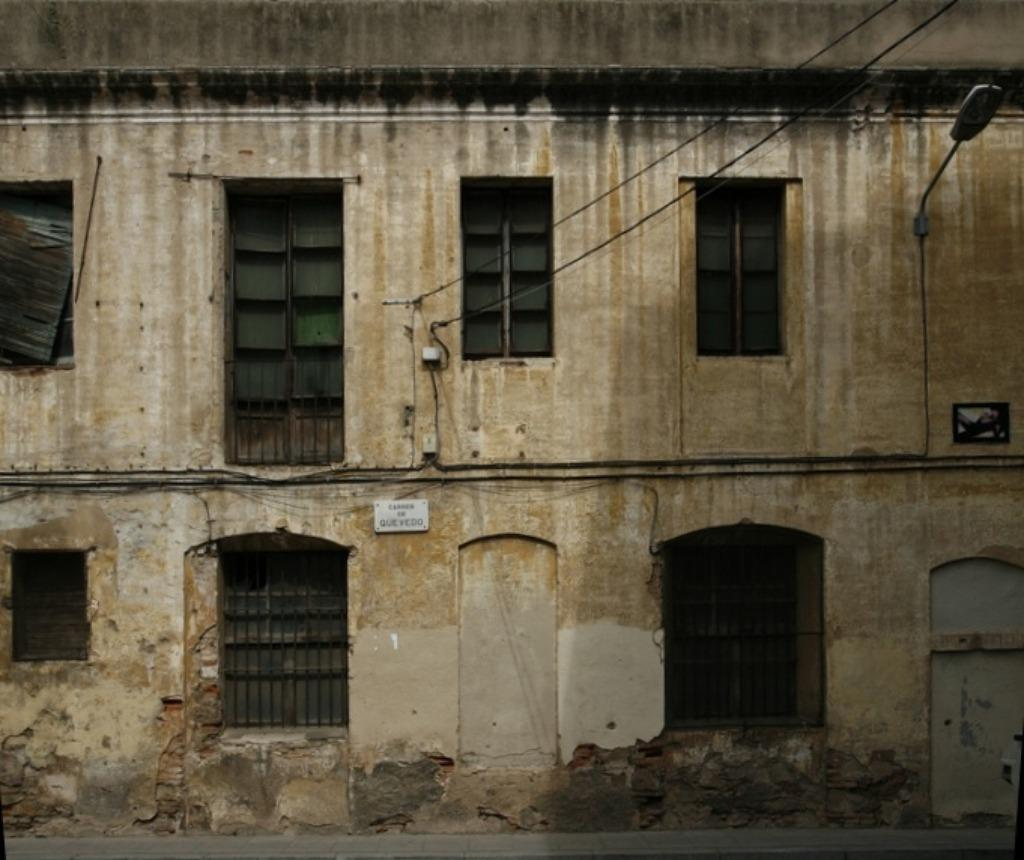

In [22]:
from PIL import Image
image = Image.open('./test_images/extended/cmp_x0001.jpg')
image

In [23]:
 #prepare the image for the model
encoding = feature_extractor(image, return_tensors="pt")
pixel_values = encoding.pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 512, 512])


In [24]:
# forward pass
outputs = model(pixel_values=pixel_values)

In [25]:
# logits are of shape (batch_size, num_labels, height/4, width/4)
logits = outputs.logits.cpu()
print(logits.shape)

torch.Size([1, 13, 128, 128])


In [26]:
def ade_palette():
    """ADE20K palette that maps each class to RGB values."""
    return [
        [  0,   0,   0],
        [  0,   0, 170],
        [  0,   0, 255],
        [  0,  85, 255],
        [  0, 170, 255],
        [  0, 255, 255],
        [ 85, 255, 170],
        [170,   0,   0],
        [170, 255,  85],
        [255,   0,   0],
        [255,  85,   0],
        [255, 170,   0],
        [255, 255,   0]]

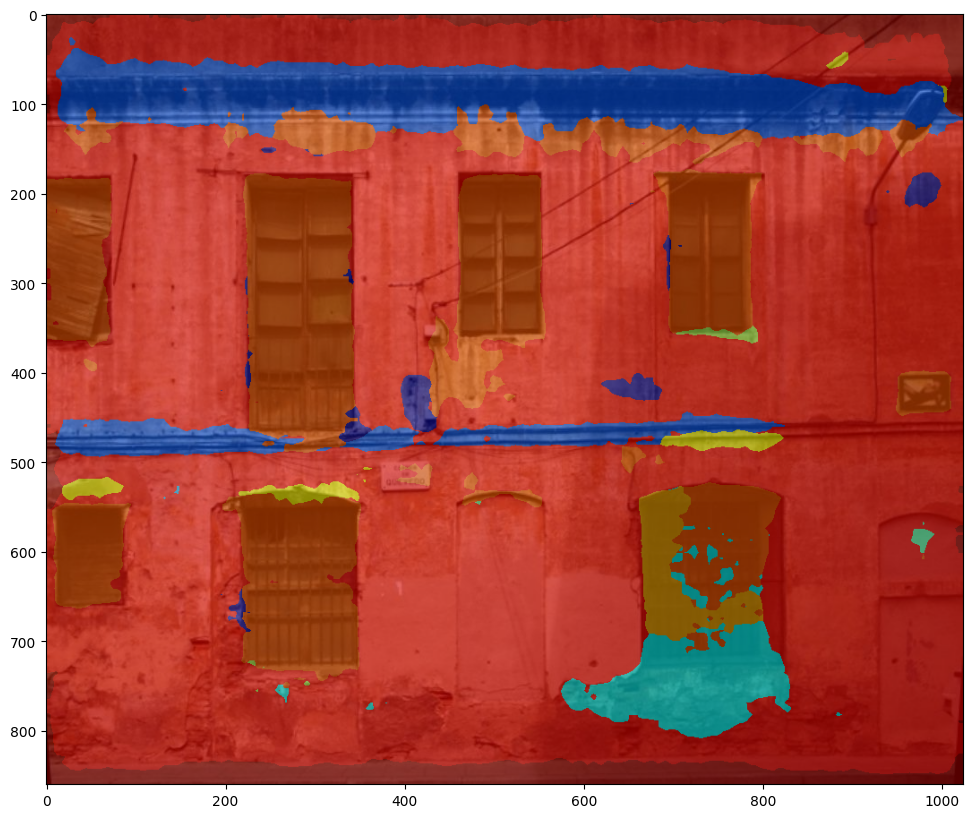

In [27]:
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

# First, rescale logits to original image size
upsampled_logits = nn.functional.interpolate(logits,
                size=image.size[::-1], # (height, width)
                mode='bilinear',
                align_corners=False)

# Second, apply argmax on the class dimension
seg = upsampled_logits.argmax(dim=1)[0]
color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3
palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[seg == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

In [28]:
map = Image.open('./test_images/extended/cmp_x0001.png') 
 

Classes in this image: ['LABEL_0', 'LABEL_1', 'LABEL_2', 'LABEL_6', 'LABEL_7', 'LABEL_9']


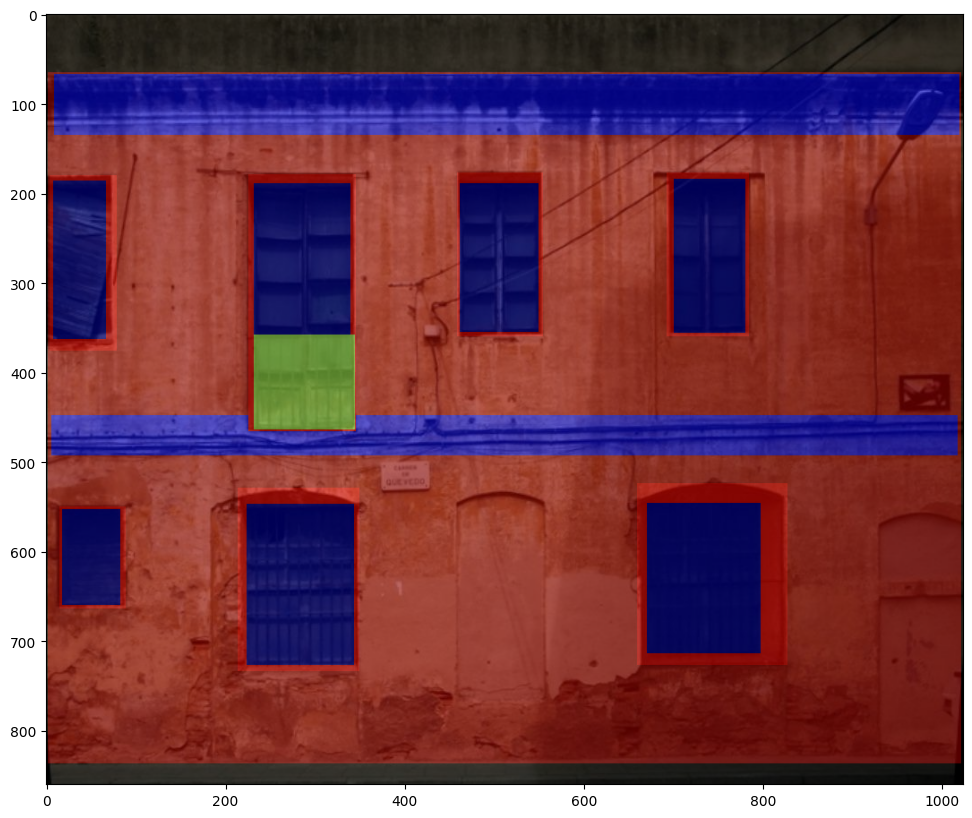

In [29]:
#convert map to NumPy array
map = np.array(map)
map[map == 0] = 255 # background class is replaced by ignore_index
map = map - 1 # other classes are reduced by one
map[map == 254] = 255

classes_map = np.unique(map).tolist()
unique_classes = [model.config.id2label[idx] if idx!=255 else None for idx in classes_map]
print("Classes in this image:", unique_classes)

# create coloured map
color_seg = np.zeros((map.shape[0], map.shape[1], 3), dtype=np.uint8) # height, width, 3
palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[map == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

In [30]:
seg.unique()

tensor([ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12])

In [31]:

np.unique(map)

array([0, 1, 2, 6, 7, 9], dtype=uint8)

In [32]:
seg

tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])

In [33]:
map

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [56]:
# metric expects a list of numpy arrays for both predictions and references
metrics = metric.compute(predictions=[seg.numpy()], references=[map], num_labels=13, ignore_index=0)

C:\Users\DooFromash\.cache\huggingface\modules\datasets_modules\metrics\mean_iou\d4add40cf977cdd73590b5873fa830f3f13adb678f6777a29fb07b7c81d14342\mean_iou.py:258: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\DooFromash\.cache\huggingface\modules\datasets_modules\metrics\mean_iou\d4add40cf977cdd73590b5873fa830f3f13adb678f6777a29fb07b7c81d14342\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


In [34]:
metrics.keys()

dict_keys(['mean_iou', 'mean_accuracy', 'overall_accuracy', 'per_category_iou', 'per_category_accuracy'])

In [35]:
import pandas as pd

# print overall metrics
for key in list(metrics.keys())[:3]:
  print(key, metrics[key])


mean_iou 0.6330314910451563
mean_accuracy 0.7436569047666767
overall_accuracy 0.8055896759033203


In [36]:
id2label.items()

dict_items([(0, 'unknown'), (1, 'background'), (2, 'facade'), (3, 'window'), (4, 'door'), (5, 'cornice'), (6, 'sill'), (7, 'balcony'), (8, 'blind'), (9, 'pillar'), (10, 'deco'), (11, 'molding'), (12, 'shop')])

In [37]:
# pretty-print per category metrics as Pandas DataFrame
metric_table = dict()
for id, label in id2label.items():
    metric_table[label] = [
                           metrics["per_category_iou"][id],
                           metrics["per_category_accuracy"][id]
    ]

print("---------------------")
print("per-category metrics:")
pd.DataFrame.from_dict(metric_table, orient="index", columns=["IoU", "accuracy"])

---------------------
per-category metrics:


IoU  accuracy
unknown          NaN       NaN
background  0.496570  0.571558
facade      0.734714  0.911956
window      0.689787  0.906423
door        0.810231  0.919194
cornice     0.674727  0.781948
sill        0.676218  0.825725
balcony     0.689760  0.770124
blind       0.759333  0.836336
pillar      0.432238  0.486056
deco        0.710184  0.894454
molding     0.197044  0.221958
shop        0.725573  0.798152